In [8]:
import torch
import torchvision
import numpy as np

In [9]:
n_epochs = 5 # set to 5 for base model
batch_size_train = 64
batch_size_test = 640
learning_rate = 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [10]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x, features=False):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [14]:
network = Net().cpu()
optimizer = optim.Adam(network.parameters(), lr=1e-3)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
С = -20
# С = -0.5

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):

    # optimizer.zero_grad()
    # inputs = torch.cat([data, target.reshape(-1, 1, 1, 1) * torch.ones_like(data) / 10.], dim=1).cuda()
    # output = network(inputs)
    # loss = F.nll_loss(output, target.cuda())
    # loss.backward()
    # optimizer.step()

    # optimizer.zero_grad()
    # inputs = torch.cat([data, -torch.ones_like(data)], dim=1).cuda()
    # output = network(inputs)
    # loss = F.nll_loss(output, target.cuda())
    # loss.backward()
    # optimizer.step()

    optimizer.zero_grad()
    inputs_1 = torch.cat([data, С*torch.ones_like(data)], dim=1).cpu()

    # t_inputs = (target + 0.1*torch.randn(target.shape)).reshape(-1, 1, 1, 1) * torch.ones_like(data)
    t_inputs = target.reshape(-1, 1, 1, 1) * torch.ones_like(data)
    inputs_2 = torch.cat([data, t_inputs], dim=1).cpu()

    p = 0.5
    mask = (torch.empty(inputs_1.shape[0], 1, 1, 1).uniform_(0, 1) > p).float().cpu()
    inputs = inputs_1 * mask + inputs_2 * (1 - mask)
    target = target

    output = network(inputs, features=False)

    loss = F.nll_loss(output, target.cpu()) #+ reg
    # print(loss, reg)
    loss.backward()
    optimizer.step()

    loss = loss.cpu()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/vanilla_model.pth')
      torch.save(optimizer.state_dict(), '/vanilla_optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      # inputs = data.cuda()
      inputs = torch.cat([data, С*torch.ones_like(data)], dim=1).cpu()
      # inputs = (data + С*torch.ones_like(data)).cuda()
      output = network(inputs).cpu()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100 * correct / len(test_loader.dataset)

In [23]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-13-5adc203d06af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3181, Accuracy: 958/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296962
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279510
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.164294
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.984613
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.948497
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.690720
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.329213
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.178036
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.997572
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.543486
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.593093
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.702679
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.498126
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.414730
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.538169
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.324108
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.273956
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.315784
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.317373
Train Epoch: 1 [12160/

In [24]:
train_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15130826.61it/s]


Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267576.09it/s]


Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5038780.48it/s]


Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5940103.71it/s]

Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



In [28]:
# Computing OOD metrics

network.eval()

uncertainties = np.array([])
labels = np.array([])
vectors = np.array([[]]).reshape([0, 10])
vectors_2 = np.array([[]]).reshape([0, 10])

C = -20
N = 1
eps = 0

with torch.no_grad():
  for data, target in test_loader:
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    # inputs = (data + C*torch.ones_like(data)).cuda()
    output = network(inputs, features=True)
    output = torch.softmax(output, dim=1)
    pred_target = torch.argmax(output, dim=1)
    # pred_input = pred_target
    pred_input = output.topk(1).indices[:, -1]

    for _ in range(N):
      inputs = torch.cat([data.cpu(), pred_input.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
      output_w = network(inputs, features=True)
      output_w = torch.softmax(output_w, dim=1)
      pred_target = torch.argmax(output_w, dim=1) + eps

    # uncertainty = torch.abs(output - output_w).max(dim=1)[0].detach().cpu()
    uncertainty = torch.abs(output - output_w).mean(dim=1).cpu()

    label = np.zeros_like(uncertainty)

    # vectors = np.concatenate([vectors, z_without.cpu()])
    # vectors_2 = np.concatenate([vectors_2, z_with.cpu()])
    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

with torch.no_grad():
  for data, target in test_fashion_loader:
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    # inputs = (data + C*torch.ones_like(data)).cuda()
    output = network(inputs, features=True)
    output = torch.softmax(output, dim=1)
    pred_target = torch.argmax(output, dim=1) + eps

    # pred_input = pred_target
    pred_input = output.topk(1).indices[:, -1]

    for _ in range(N):
      inputs = torch.cat([data.cpu(), pred_input.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
      output_w = network(inputs, features=True)
      output_w = torch.softmax(output_w, dim=1)
      pred_target = torch.argmax(output_w, dim=1)

    # uncertainty = torch.abs(output - output_w).max(dim=1)[0].detach().cpu()
    uncertainty = torch.abs(output - output_w).mean(dim=1).cpu()

    label = np.ones_like(uncertainty)

    # vectors = np.concatenate([vectors, z_without.cpu()])
    # vectors_2 = np.concatenate([vectors_2, z_with.cpu()])
    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

import sklearn.metrics
roc_auc = sklearn.metrics.roc_auc_score(labels, uncertainties)
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, uncertainties)
pr_auc = sklearn.metrics.auc(recall, precision)

print(f"SINGLE MNIST ROC AUC: {roc_auc} PR AUC: {pr_auc}")

<ipython-input-13-5adc203d06af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


SINGLE MNIST ROC AUC: 0.9822305000000001 PR AUC: 0.9782993549537198


In [35]:
network.eval()

uncertainties = np.array([])
deltas = np.array([])
losses = np.array([])
labels = np.array([])

vectors = np.array([[]]).reshape([0, 10])
vectors_2 = np.array([[]]).reshape([0, 10])

C = -20

with torch.no_grad():
  for data, target in test_loader:
    # target = target.cuda()
    target_onehot = torch.nn.functional.one_hot(target, 10).cpu()
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    # inputs = (data + C*torch.ones_like(data)).cuda()
    output = network(inputs, features=True)

    nll_loss = F.nll_loss(output, target.cpu(), reduction='none').cpu()

    pred_target = torch.argmax(output, dim=1)
    inputs = torch.cat([data.cpu(), pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    # inputs = (data.cuda() + pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cuda()).cuda()
    output_w = network(inputs, features=True)

    # for delta compute
    inputs = torch.cat([data.cpu(), target.cpu().reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    output_t = network(inputs, features=True)

    uncertainty = torch.abs(torch.nn.functional.softmax(output) - torch.nn.functional.softmax(output_w)).min(dim=1)[0].detach().cpu() #torch.abs(output - output_w).mean(dim=1).cpu()
    delta = torch.abs(target_onehot - torch.nn.functional.softmax(output_t)).min(dim=1)[0].detach().cpu()

    label = (pred_target.cpu() == target).cpu()

    # vectors = np.concatenate([vectors, z_without.cpu()])
    # vectors_2 = np.concatenate([vectors_2, z_with.cpu()])
    uncertainties = np.concatenate([uncertainties, uncertainty])
    deltas = np.concatenate([deltas, delta])
    labels = np.concatenate([labels, label])
    losses = np.concatenate([losses, nll_loss])

<ipython-input-13-5adc203d06af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
<ipython-input-35-10840cb8b1e3>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  uncertainty = torch.abs(torch.nn.functional.softmax(output) - torch.nn.functional.softmax(output_w)).min(dim=1)[0].detach().cpu() #torch.abs(output - output_w).mean(dim=1).cpu()
<ipython-input-35-10840cb8b1e3>:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  delta = torch.abs(target_onehot - torch.nn.functional.softmax(output_t)).min(dim=1)[0].detach().cpu()


In [36]:
network.eval()

uncertainties = np.array([])
deltas = np.array([])
labels = np.array([])
errs = []

vectors = np.array([[]]).reshape([0, 10])
vectors_2 = np.array([[]]).reshape([0, 10])

C = -20
eps = 0

with torch.no_grad():
  for data, target in test_loader:
    # target = target.cuda()
    target_onehot = torch.nn.functional.one_hot(target, 10).cpu()
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    # inputs = (data + C*torch.ones_like(data)).cuda()
    output = network(inputs, features=True)
    pred_target = torch.argmax(output, dim=1)
    # pred_input = (pred_target + eps)
    pred_input = output.topk(1).indices[:, -1]
    inputs = torch.cat([data.cpu(), pred_input.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    # inputs = (data.cuda() + pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cuda()).cuda()
    output_w = network(inputs, features=True)

    # for delta compute
    inputs = torch.cat([data.cpu(), target.cpu().reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    output_t = network(inputs, features=True)

    # uncertainty = torch.abs(output - output_w).min(dim=1)[0].detach().cpu()
    # uncertainty = torch.abs(torch.softmax(output, dim=1) - torch.softmax(output_w, dim=1)).max(dim=1)[0].detach().cpu()
    uncertainty = torch.abs(torch.softmax(output, dim=1) - torch.softmax(output_w, dim=1)).mean(dim=1).detach().cpu()
    delta = torch.abs(target_onehot - output_t).min(dim=1)[0].detach().cpu()

    loss = torch.nn.CrossEntropyLoss(reduction="none")
    err = loss(output, pred_target.cpu()).tolist()
    errs += err

    label = (pred_target.cpu() == target).cpu()

    # vectors = np.concatenate([vectors, z_without.cpu()])
    # vectors_2 = np.concatenate([vectors_2, z_with.cpu()])
    uncertainties = np.concatenate([uncertainties, uncertainty])
    deltas = np.concatenate([deltas, delta])
    labels = np.concatenate([labels, label])

<ipython-input-13-5adc203d06af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0.01653513499589576 0.016018823067625476
0.9687748586027002


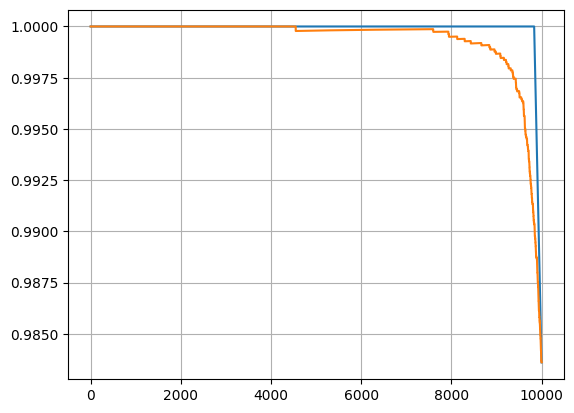

In [38]:
import numpy as np

def AULC(accs, uncertainties):
  idxs = np.argsort(uncertainties)
  uncs_s = uncertainties[idxs]
  error_s = accs[idxs]

  mean_error = error_s.mean()
  error_csum = np.cumsum(error_s)

  Fs = error_csum / np.arange(1, len(error_s) + 1)
  s = 1 / len(Fs)
  return -1 + s * Fs.sum() / mean_error, Fs

def rAULC(uncertainties, accs):
    perf_aulc, Fsp = AULC(accs, -accs.astype("float"))
    curr_aulc, Fsc = AULC(accs, uncertainties)
    print(perf_aulc, curr_aulc)
    return curr_aulc / perf_aulc, Fsp, Fsc

res, r1, r2 = rAULC(uncertainties, labels)
print(res)

import matplotlib.pyplot as plt
plt.plot(range(len(r1)), r1)
plt.plot(range(len(r1)), r2)
plt.grid()